<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase1/blob/master/EVA4_S6_Regularization_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

## Data Transformations



In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                       transforms.RandomRotation((-7,7),fill=(1,)),
                                      #  transforms.RandomHorizontalFlip(),
                                      #  transforms.RandomErasing(p=0.2), 
                                       transforms.ToTensor(),                                       
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [13]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 28x28x1 , out = 26x26x16, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 26x26x16 , out = 24x24x16, RF = 5
 
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # in = 24x24x16 , out = 12x12x16, RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 12x12x16 , out = 10x10x16, RF = 10
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 10x10x16 , out = 8x8x16, RF = 14

        # OUTPUT BLOCK
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 8x8x16 , out = 6x6x16, RF = 18
        self.Gap1 = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # in = 6x6x16 , out = 1x1x16, RF = 28	
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # in = 1x1x16 , out = 1x1x10, RF = 28

    def forward(self, x):
        x = self.convblock2(self.convblock1(x))
        x = self.pool1(x)
        x = self.convblock4(self.convblock3(x))
        x = self.Gap1(self.convblock5(x))
        x = self.fc1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [15]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           2,304
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [

# Training and Testing

In [0]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, factor):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  i = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    L1_Crit = nn.L1Loss(size_average=None, reduce=None, reduction='mean')
    reg_loss = 0 
    for param in model.parameters():
      zero_vector = torch.rand_like(param) * 0
      reg_loss += L1_Crit(param,zero_vector)
    loss += factor * reg_loss
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    # in view() method the shape of the desired output tensor is to be passed in as the parameter,
    # whereas in view_as() a tensor whose shape is to be mimicked it passed.
    # tensor.view_as(other) is equivalent to tensor.view(other.size())
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    if batch_idx == 468:
      train_acc_epoch.append(100*correct/processed)
      train_losses_epoch.append(loss)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    i = 0
    with torch.no_grad():

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            idx_incorrect = pred.ne(target.view_as(pred)).view(-1)
            actual_img.append(data[idx_incorrect.nonzero()].cpu().numpy())
            wrong_pred.append(pred[idx_incorrect.nonzero()].cpu().numpy())
            actual_target.append(target[idx_incorrect.nonzero()].cpu().numpy())
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
def save_image(orig_img,wrong_class,right_class):

    orig_wrong_right  = []
    orig_img_s1       = []
    wrong_class_s0    = []
    wrong_class_s1    = []
    right_class_s0    = []
    right_class_s1    = []

    for i in range(len(orig_img)):
        if orig_img[i].shape[0] == 1:                              # Only take those images whose batch-size is 1 to avoid reshape issues
          orig_img_s1.append(orig_img[i])
          wrong_class_s0.append(wrong_class[i].reshape(1))         # For the orig image, we are capturing its wrong class predicted by model
          right_class_s0.append(right_class[i].reshape(1))         # For the orig image, we are capturing its right class present in target

    for i in range(len(wrong_class_s0)):
        wrong_class_s1.append(wrong_class_s0[i][0])  # We are reducing the wrong_class to 1 dimension for ease of display using 'print'
        right_class_s1.append(right_class_s0[i][0])  # We are reducing the wrong_class to 1 dimension for ease of display using 'print'
    
    orig_wrong_right.append(orig_img_s1)
    orig_wrong_right.append(wrong_class_s1)
    orig_wrong_right.append(right_class_s1)

    return orig_wrong_right

# Running the Model in order (1) w/o L1 or L2 (2) With L1 (3) With L2 (4) With L1 & L2

In [18]:
from torch.optim.lr_scheduler import StepLR
%matplotlib inline
import matplotlib.pyplot as plt

val_accuracy = []  # To store val_accuracy for models (a) w/o L1 or L2 (b) With L1 (c) With L2 (d) With L1 & L2
loss_test    = []  # To save test losses as above
loss_train   = []  # To save train losses as above
act_img      = []  # To save 25 actual images which got misclassified for each of the above models
pred_class   = []  # To save predicted class for above images
act_class    = []  # To save actual class for above images

factor_list  = [(0,0),(0.0005,0),(0,0.0001),(0.0005,0.0001)]  # List of tuples (L1,L2) for 4 above models

for factors in factor_list:
    L1_factor,L2_factor = factors
    print('L1_Factor :',L1_factor,'L2_factor :',L2_factor)
    train_losses        = []
    test_losses         = []
    train_acc           = []
    test_acc            = []
    train_acc_epoch     = []
    train_losses_epoch  = []

    actual_img          = []
    wrong_pred          = []
    actual_target       = []   

    model =  Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.9,weight_decay=L2_factor)    
    scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

    EPOCHS = 40
    factor_in = L1_factor
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch)
        train(model, device, train_loader, optimizer, epoch, factor_in)
        test(model, device, test_loader)
    
    val_accuracy.append(test_acc)
    loss_test.append(test_losses) 
    loss_train.append(train_losses_epoch) 

    incorrect_pred = []
    incorrect_pred = save_image(actual_img,wrong_pred,actual_target)

    act_img.append(incorrect_pred[0])
    pred_class.append(incorrect_pred[1])
    act_class.append(incorrect_pred[2])

    print('\nMaxium test accuracy: {:.2f}, Achieved in epoch: {}, Max Train accuracy : {:.2f}, Achieved in epoch : {}\n'.format(
           max(test_acc),  np.argmax(test_acc) , max(train_acc_epoch), np.argmax(train_acc_epoch)))   


  0%|          | 0/469 [00:00<?, ?it/s]

L1_Factor : 0 L2_factor : 0
EPOCH: 0


Loss=0.12788721919059753 Batch_id=468 Train Accuracy=91.70: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Test Accuracy: 9829/10000 (98.29%)

EPOCH: 1


Loss=0.03680182993412018 Batch_id=468 Train Accuracy=98.02: 100%|██████████| 469/469 [00:20<00:00, 22.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Test Accuracy: 9887/10000 (98.87%)

EPOCH: 2


Loss=0.05784773454070091 Batch_id=468 Train Accuracy=98.48: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Test Accuracy: 9881/10000 (98.81%)

EPOCH: 3


Loss=0.041915640234947205 Batch_id=468 Train Accuracy=98.67: 100%|██████████| 469/469 [00:20<00:00, 22.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Test Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Loss=0.008370275609195232 Batch_id=468 Train Accuracy=98.75: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Test Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.06280840933322906 Batch_id=468 Train Accuracy=98.80: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Test Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.01674264669418335 Batch_id=468 Train Accuracy=98.92: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.00976302195340395 Batch_id=468 Train Accuracy=99.00: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.08810809254646301 Batch_id=468 Train Accuracy=99.07: 100%|██████████| 469/469 [00:20<00:00, 22.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.023936817422509193 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:20<00:00, 23.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Test Accuracy: 9941/10000 (99.41%)

EPOCH: 10


Loss=0.06438804417848587 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 11


Loss=0.016848787665367126 Batch_id=468 Train Accuracy=99.17: 100%|██████████| 469/469 [00:20<00:00, 29.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.016902387142181396 Batch_id=468 Train Accuracy=99.15: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.021568262949585915 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:19<00:00, 23.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.0013889521360397339 Batch_id=468 Train Accuracy=99.26: 100%|██████████| 469/469 [00:20<00:00, 22.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.008684150874614716 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 16


Loss=0.010709653608500957 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:19<00:00, 23.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.0050637670792639256 Batch_id=468 Train Accuracy=99.35: 100%|██████████| 469/469 [00:20<00:00, 22.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 18


Loss=0.010236452333629131 Batch_id=468 Train Accuracy=99.28: 100%|██████████| 469/469 [00:20<00:00, 22.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.08837860822677612 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:20<00:00, 22.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 20


Loss=0.01912028156220913 Batch_id=468 Train Accuracy=99.32: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 21


Loss=0.04555590823292732 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:20<00:00, 22.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Loss=0.004755472298711538 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:20<00:00, 22.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Test Accuracy: 9941/10000 (99.41%)

EPOCH: 23


Loss=0.011085410602390766 Batch_id=468 Train Accuracy=99.34: 100%|██████████| 469/469 [00:20<00:00, 23.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 24


Loss=0.04066262021660805 Batch_id=468 Train Accuracy=99.37: 100%|██████████| 469/469 [00:20<00:00, 23.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 25


Loss=0.003030071733519435 Batch_id=468 Train Accuracy=99.38: 100%|██████████| 469/469 [00:20<00:00, 22.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Test Accuracy: 9943/10000 (99.43%)

EPOCH: 26


Loss=0.001781617640517652 Batch_id=468 Train Accuracy=99.43: 100%|██████████| 469/469 [00:20<00:00, 22.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 27


Loss=0.0075373402796685696 Batch_id=468 Train Accuracy=99.39: 100%|██████████| 469/469 [00:20<00:00, 23.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Test Accuracy: 9945/10000 (99.45%)

EPOCH: 28


Loss=0.05547035112977028 Batch_id=468 Train Accuracy=99.41: 100%|██████████| 469/469 [00:20<00:00, 25.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Test Accuracy: 9945/10000 (99.45%)

EPOCH: 29


Loss=0.018964767456054688 Batch_id=468 Train Accuracy=99.40: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 30


Loss=0.05661581829190254 Batch_id=468 Train Accuracy=99.41: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 31


Loss=0.004087830428034067 Batch_id=468 Train Accuracy=99.42: 100%|██████████| 469/469 [00:20<00:00, 23.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Test Accuracy: 9941/10000 (99.41%)

EPOCH: 32


Loss=0.006588488817214966 Batch_id=468 Train Accuracy=99.40: 100%|██████████| 469/469 [00:20<00:00, 28.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 33


Loss=0.0012177625903859735 Batch_id=468 Train Accuracy=99.50: 100%|██████████| 469/469 [00:20<00:00, 22.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 34


Loss=0.012414966709911823 Batch_id=468 Train Accuracy=99.42: 100%|██████████| 469/469 [00:20<00:00, 23.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 35


Loss=0.012049049139022827 Batch_id=468 Train Accuracy=99.46: 100%|██████████| 469/469 [00:20<00:00, 23.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 36


Loss=0.0023963749408721924 Batch_id=468 Train Accuracy=99.48: 100%|██████████| 469/469 [00:20<00:00, 22.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Test Accuracy: 9941/10000 (99.41%)

EPOCH: 37


Loss=0.006295864935964346 Batch_id=468 Train Accuracy=99.47: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 38


Loss=0.008133579976856709 Batch_id=468 Train Accuracy=99.46: 100%|██████████| 469/469 [00:20<00:00, 23.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Test Accuracy: 9947/10000 (99.47%)

EPOCH: 39


Loss=0.0478643961250782 Batch_id=468 Train Accuracy=99.44: 100%|██████████| 469/469 [00:20<00:00, 28.23it/s]



Test set: Average loss: 0.0191, Test Accuracy: 9941/10000 (99.41%)


Maxium test accuracy: 99.47, Achieved in epoch: 38, Max Train accuracy : 99.50, Achieved in epoch : 33

L1_Factor : 0.0005 

  0%|          | 0/469 [00:00<?, ?it/s]

L2_factor : 0
EPOCH: 0


Loss=0.06910376995801926 Batch_id=468 Train Accuracy=92.02: 100%|██████████| 469/469 [00:20<00:00, 23.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Test Accuracy: 9862/10000 (98.62%)

EPOCH: 1


Loss=0.10083726048469543 Batch_id=468 Train Accuracy=98.25: 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Test Accuracy: 9882/10000 (98.82%)

EPOCH: 2


Loss=0.05962558835744858 Batch_id=468 Train Accuracy=98.51: 100%|██████████| 469/469 [00:20<00:00, 22.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Test Accuracy: 9912/10000 (99.12%)

EPOCH: 3


Loss=0.10019232332706451 Batch_id=468 Train Accuracy=98.66: 100%|██████████| 469/469 [00:20<00:00, 23.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Test Accuracy: 9909/10000 (99.09%)

EPOCH: 4


Loss=0.015972565859556198 Batch_id=468 Train Accuracy=98.84: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Test Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.04247172549366951 Batch_id=468 Train Accuracy=98.91: 100%|██████████| 469/469 [00:20<00:00, 22.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Test Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Loss=0.010874822735786438 Batch_id=468 Train Accuracy=99.00: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Test Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.01234467327594757 Batch_id=468 Train Accuracy=99.01: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Test Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.03750300034880638 Batch_id=468 Train Accuracy=98.97: 100%|██████████| 469/469 [00:20<00:00, 29.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Test Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.06641701608896255 Batch_id=468 Train Accuracy=99.12: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.01923467218875885 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:20<00:00, 22.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.014604242518544197 Batch_id=468 Train Accuracy=99.18: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Test Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.015178403817117214 Batch_id=468 Train Accuracy=99.21: 100%|██████████| 469/469 [00:20<00:00, 29.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.04334254190325737 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.025170309469103813 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:20<00:00, 23.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.07410451024770737 Batch_id=468 Train Accuracy=99.27: 100%|██████████| 469/469 [00:20<00:00, 22.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.02265741676092148 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:20<00:00, 22.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Test Accuracy: 9923/10000 (99.23%)

EPOCH: 17


Loss=0.020928701385855675 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:19<00:00, 23.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 18


Loss=0.014105267822742462 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:20<00:00, 22.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 19


Loss=0.016873151063919067 Batch_id=468 Train Accuracy=99.26: 100%|██████████| 469/469 [00:20<00:00, 23.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 20


Loss=0.010729053989052773 Batch_id=468 Train Accuracy=99.32: 100%|██████████| 469/469 [00:20<00:00, 22.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 21


Loss=0.06774028390645981 Batch_id=468 Train Accuracy=99.30: 100%|██████████| 469/469 [00:20<00:00, 28.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 22


Loss=0.05756697803735733 Batch_id=468 Train Accuracy=99.34: 100%|██████████| 469/469 [00:20<00:00, 27.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 23


Loss=0.006892319768667221 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:20<00:00, 22.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Test Accuracy: 9926/10000 (99.26%)

EPOCH: 24


Loss=0.02472732402384281 Batch_id=468 Train Accuracy=99.35: 100%|██████████| 469/469 [00:20<00:00, 23.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 25


Loss=0.02674923650920391 Batch_id=468 Train Accuracy=99.35: 100%|██████████| 469/469 [00:20<00:00, 23.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 26


Loss=0.006523117423057556 Batch_id=468 Train Accuracy=99.35: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 27


Loss=0.005476352293044329 Batch_id=468 Train Accuracy=99.35: 100%|██████████| 469/469 [00:20<00:00, 22.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 28


Loss=0.016167450696229935 Batch_id=468 Train Accuracy=99.36: 100%|██████████| 469/469 [00:19<00:00, 23.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 29


Loss=0.007406470365822315 Batch_id=468 Train Accuracy=99.41: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 30


Loss=0.013371013104915619 Batch_id=468 Train Accuracy=99.38: 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 31


Loss=0.015961116179823875 Batch_id=468 Train Accuracy=99.41: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 32


Loss=0.027019545435905457 Batch_id=468 Train Accuracy=99.42: 100%|██████████| 469/469 [00:20<00:00, 22.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 33


Loss=0.023215876892209053 Batch_id=468 Train Accuracy=99.39: 100%|██████████| 469/469 [00:21<00:00, 21.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 34


Loss=0.006802879739552736 Batch_id=468 Train Accuracy=99.43: 100%|██████████| 469/469 [00:21<00:00, 21.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 35


Loss=0.016668863594532013 Batch_id=468 Train Accuracy=99.41: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 36


Loss=0.005558328237384558 Batch_id=468 Train Accuracy=99.44: 100%|██████████| 469/469 [00:21<00:00, 26.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 37


Loss=0.006916671991348267 Batch_id=468 Train Accuracy=99.47: 100%|██████████| 469/469 [00:21<00:00, 25.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 38


Loss=0.01943037286400795 Batch_id=468 Train Accuracy=99.48: 100%|██████████| 469/469 [00:21<00:00, 21.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 39


Loss=0.04643040522933006 Batch_id=468 Train Accuracy=99.45: 100%|██████████| 469/469 [00:21<00:00, 21.92it/s]



Test set: Average loss: 0.0188, Test Accuracy: 9943/10000 (99.43%)


Maxium test accuracy: 99.43, Achieved in epoch: 39, Max Train accuracy : 99.48, Achieved in epoch : 38

L1_Factor : 0 L2_factor : 

  0%|          | 0/469 [00:00<?, ?it/s]

0.0001
EPOCH: 0


Loss=0.08460918068885803 Batch_id=468 Train Accuracy=91.57: 100%|██████████| 469/469 [00:20<00:00, 22.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0639, Test Accuracy: 9829/10000 (98.29%)

EPOCH: 1


Loss=0.040842171758413315 Batch_id=468 Train Accuracy=97.95: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Test Accuracy: 9890/10000 (98.90%)

EPOCH: 2


Loss=0.11177954822778702 Batch_id=468 Train Accuracy=98.34: 100%|██████████| 469/469 [00:20<00:00, 28.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Test Accuracy: 9877/10000 (98.77%)

EPOCH: 3


Loss=0.023127049207687378 Batch_id=468 Train Accuracy=98.48: 100%|██████████| 469/469 [00:20<00:00, 22.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Test Accuracy: 9893/10000 (98.93%)

EPOCH: 4


Loss=0.012049411423504353 Batch_id=468 Train Accuracy=98.74: 100%|██████████| 469/469 [00:19<00:00, 23.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Test Accuracy: 9917/10000 (99.17%)

EPOCH: 5


Loss=0.01890833117067814 Batch_id=468 Train Accuracy=98.83: 100%|██████████| 469/469 [00:20<00:00, 23.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Test Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.01452876627445221 Batch_id=468 Train Accuracy=98.81: 100%|██████████| 469/469 [00:20<00:00, 22.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Test Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.017949065193533897 Batch_id=468 Train Accuracy=98.92: 100%|██████████| 469/469 [00:20<00:00, 22.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Test Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.055287379771471024 Batch_id=468 Train Accuracy=99.00: 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Test Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.03575366735458374 Batch_id=468 Train Accuracy=98.98: 100%|██████████| 469/469 [00:20<00:00, 22.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.053689584136009216 Batch_id=468 Train Accuracy=99.00: 100%|██████████| 469/469 [00:20<00:00, 22.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.013073290698230267 Batch_id=468 Train Accuracy=99.04: 100%|██████████| 469/469 [00:20<00:00, 22.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.026378974318504333 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:20<00:00, 23.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.04789434373378754 Batch_id=468 Train Accuracy=99.11: 100%|██████████| 469/469 [00:20<00:00, 22.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.020347097888588905 Batch_id=468 Train Accuracy=99.16: 100%|██████████| 469/469 [00:20<00:00, 27.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Loss=0.015092536807060242 Batch_id=468 Train Accuracy=99.17: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.009106229059398174 Batch_id=468 Train Accuracy=99.21: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Test Accuracy: 9922/10000 (99.22%)

EPOCH: 17


Loss=0.02862202189862728 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:20<00:00, 25.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Test Accuracy: 9921/10000 (99.21%)

EPOCH: 18


Loss=0.007866491563618183 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:20<00:00, 28.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 19


Loss=0.028531884774565697 Batch_id=468 Train Accuracy=99.19: 100%|██████████| 469/469 [00:20<00:00, 22.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 20


Loss=0.04529273882508278 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:20<00:00, 23.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Test Accuracy: 9913/10000 (99.13%)

EPOCH: 21


Loss=0.02219381369650364 Batch_id=468 Train Accuracy=99.27: 100%|██████████| 469/469 [00:20<00:00, 22.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 22


Loss=0.004901304841041565 Batch_id=468 Train Accuracy=99.26: 100%|██████████| 469/469 [00:20<00:00, 22.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 23


Loss=0.013180832378566265 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 24


Loss=0.007164756301790476 Batch_id=468 Train Accuracy=99.27: 100%|██████████| 469/469 [00:20<00:00, 29.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 25


Loss=0.0037734806537628174 Batch_id=468 Train Accuracy=99.26: 100%|██████████| 469/469 [00:20<00:00, 22.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Test Accuracy: 9941/10000 (99.41%)

EPOCH: 26


Loss=0.008010785095393658 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:20<00:00, 22.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 27


Loss=0.05030063912272453 Batch_id=468 Train Accuracy=99.35: 100%|██████████| 469/469 [00:20<00:00, 23.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Test Accuracy: 9943/10000 (99.43%)

EPOCH: 28


Loss=0.005476057529449463 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:20<00:00, 23.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 29


Loss=0.026338031515479088 Batch_id=468 Train Accuracy=99.24: 100%|██████████| 469/469 [00:20<00:00, 23.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 30


Loss=0.013131007552146912 Batch_id=468 Train Accuracy=99.34: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 31


Loss=0.004015619400888681 Batch_id=468 Train Accuracy=99.35: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 32


Loss=0.02064010500907898 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:20<00:00, 22.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 33


Loss=0.016711140051484108 Batch_id=468 Train Accuracy=99.36: 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 34


Loss=0.024879731237888336 Batch_id=468 Train Accuracy=99.35: 100%|██████████| 469/469 [00:20<00:00, 23.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 35


Loss=0.050515737384557724 Batch_id=468 Train Accuracy=99.34: 100%|██████████| 469/469 [00:20<00:00, 22.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 36


Loss=0.05243849381804466 Batch_id=468 Train Accuracy=99.38: 100%|██████████| 469/469 [00:20<00:00, 22.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 37


Loss=0.02289220690727234 Batch_id=468 Train Accuracy=99.38: 100%|██████████| 469/469 [00:21<00:00, 22.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Test Accuracy: 9942/10000 (99.42%)

EPOCH: 38


Loss=0.0406058244407177 Batch_id=468 Train Accuracy=99.39: 100%|██████████| 469/469 [00:20<00:00, 28.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 39


Loss=0.004676709417253733 Batch_id=468 Train Accuracy=99.36: 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]



Test set: Average loss: 0.0234, Test Accuracy: 9930/10000 (99.30%)


Maxium test accuracy: 99.43, Achieved in epoch: 27, Max Train accuracy : 99.39, Achieved in epoch : 38

L1_Factor : 

  0%|          | 0/469 [00:00<?, ?it/s]

0.0005 L2_factor : 0.0001
EPOCH: 0


Loss=0.058436986058950424 Batch_id=468 Train Accuracy=91.45: 100%|██████████| 469/469 [00:20<00:00, 22.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0896, Test Accuracy: 9735/10000 (97.35%)

EPOCH: 1


Loss=0.11561309546232224 Batch_id=468 Train Accuracy=98.04: 100%|██████████| 469/469 [00:20<00:00, 22.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Test Accuracy: 9898/10000 (98.98%)

EPOCH: 2


Loss=0.03823364898562431 Batch_id=468 Train Accuracy=98.40: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Test Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.018946245312690735 Batch_id=468 Train Accuracy=98.63: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Test Accuracy: 9885/10000 (98.85%)

EPOCH: 4


Loss=0.10167133063077927 Batch_id=468 Train Accuracy=98.78: 100%|██████████| 469/469 [00:20<00:00, 22.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Test Accuracy: 9910/10000 (99.10%)

EPOCH: 5


Loss=0.08733855187892914 Batch_id=468 Train Accuracy=98.79: 100%|██████████| 469/469 [00:20<00:00, 22.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Test Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.012024208903312683 Batch_id=468 Train Accuracy=98.90: 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Test Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.040551893413066864 Batch_id=468 Train Accuracy=98.92: 100%|██████████| 469/469 [00:20<00:00, 28.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.016596566885709763 Batch_id=468 Train Accuracy=98.96: 100%|██████████| 469/469 [00:20<00:00, 22.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.06913640350103378 Batch_id=468 Train Accuracy=99.00: 100%|██████████| 469/469 [00:20<00:00, 29.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.01533970981836319 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:20<00:00, 22.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.04069291055202484 Batch_id=468 Train Accuracy=99.03: 100%|██████████| 469/469 [00:20<00:00, 22.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Test Accuracy: 9914/10000 (99.14%)

EPOCH: 12


Loss=0.014177808538079262 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:20<00:00, 22.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.02535274438560009 Batch_id=468 Train Accuracy=99.12: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 14


Loss=0.01186435203999281 Batch_id=468 Train Accuracy=99.15: 100%|██████████| 469/469 [00:22<00:00, 21.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.020400622859597206 Batch_id=468 Train Accuracy=99.11: 100%|██████████| 469/469 [00:20<00:00, 22.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.020112061873078346 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:20<00:00, 22.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 17


Loss=0.02392910048365593 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:20<00:00, 22.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Test Accuracy: 9926/10000 (99.26%)

EPOCH: 18


Loss=0.028053386136889458 Batch_id=468 Train Accuracy=99.28: 100%|██████████| 469/469 [00:20<00:00, 22.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Test Accuracy: 9921/10000 (99.21%)

EPOCH: 19


Loss=0.010051975026726723 Batch_id=468 Train Accuracy=99.20: 100%|██████████| 469/469 [00:20<00:00, 28.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Loss=0.038921769708395004 Batch_id=468 Train Accuracy=99.26: 100%|██████████| 469/469 [00:20<00:00, 27.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Test Accuracy: 9926/10000 (99.26%)

EPOCH: 21


Loss=0.03163285553455353 Batch_id=468 Train Accuracy=99.24: 100%|██████████| 469/469 [00:20<00:00, 23.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Test Accuracy: 9941/10000 (99.41%)

EPOCH: 22


Loss=0.06948444247245789 Batch_id=468 Train Accuracy=99.27: 100%|██████████| 469/469 [00:20<00:00, 28.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Test Accuracy: 9926/10000 (99.26%)

EPOCH: 23


Loss=0.011904485523700714 Batch_id=468 Train Accuracy=99.26: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 24


Loss=0.013093462213873863 Batch_id=468 Train Accuracy=99.29: 100%|██████████| 469/469 [00:20<00:00, 22.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 25


Loss=0.0070116836577653885 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 26


Loss=0.005739239044487476 Batch_id=468 Train Accuracy=99.27: 100%|██████████| 469/469 [00:20<00:00, 23.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 27


Loss=0.07040322571992874 Batch_id=468 Train Accuracy=99.39: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 28


Loss=0.008237500675022602 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:20<00:00, 22.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 29


Loss=0.011905321851372719 Batch_id=468 Train Accuracy=99.35: 100%|██████████| 469/469 [00:20<00:00, 28.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 30


Loss=0.013184484094381332 Batch_id=468 Train Accuracy=99.36: 100%|██████████| 469/469 [00:20<00:00, 22.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 31


Loss=0.038295928388834 Batch_id=468 Train Accuracy=99.35: 100%|██████████| 469/469 [00:20<00:00, 22.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 32


Loss=0.011138174682855606 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:20<00:00, 22.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 33


Loss=0.006877581588923931 Batch_id=468 Train Accuracy=99.36: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Test Accuracy: 9942/10000 (99.42%)

EPOCH: 34


Loss=0.007264911197125912 Batch_id=468 Train Accuracy=99.35: 100%|██████████| 469/469 [00:21<00:00, 22.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 35


Loss=0.01785931922495365 Batch_id=468 Train Accuracy=99.33: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 36


Loss=0.08940331637859344 Batch_id=468 Train Accuracy=99.38: 100%|██████████| 469/469 [00:21<00:00, 21.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Test Accuracy: 9923/10000 (99.23%)

EPOCH: 37


Loss=0.011581005528569221 Batch_id=468 Train Accuracy=99.36: 100%|██████████| 469/469 [00:21<00:00, 21.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 38


Loss=0.009068844839930534 Batch_id=468 Train Accuracy=99.38: 100%|██████████| 469/469 [00:21<00:00, 21.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 39


Loss=0.019439492374658585 Batch_id=468 Train Accuracy=99.37: 100%|██████████| 469/469 [00:22<00:00, 21.15it/s]



Test set: Average loss: 0.0212, Test Accuracy: 9933/10000 (99.33%)


Maxium test accuracy: 99.42, Achieved in epoch: 33, Max Train accuracy : 99.39, Achieved in epoch : 27



# Visualizing the validation accuracy, Test loss and Train Loss for all 4 scenarios

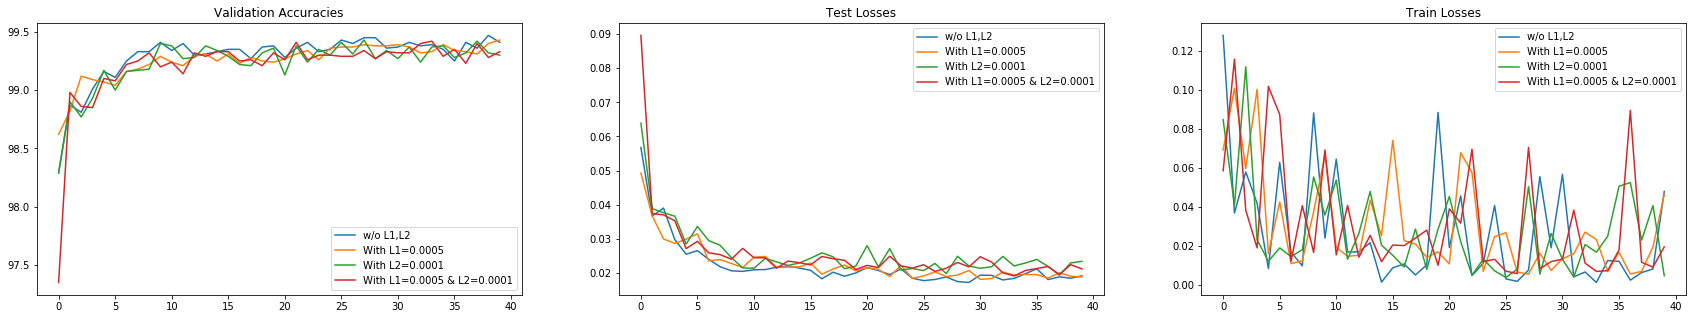

In [21]:
    figure = plt.figure(figsize=(40,5))
    labels = ['w/o L1,L2', 'With L1=0.0005', 'With L2=0.0001', 'With L1=0.0005 & L2=0.0001']

    plt.subplot(1,4,1)
    plt.title("Validation Accuracies")
    plt.plot(val_accuracy[0],label=labels[0])
    plt.plot(val_accuracy[1],label=labels[1])
    plt.plot(val_accuracy[2],label=labels[2])
    plt.plot(val_accuracy[3],label=labels[3])
    plt.legend(loc="lower right")

    plt.subplot(1,4,2)
    plt.title("Test Losses")
    plt.plot(loss_test[0],label=labels[0])
    plt.plot(loss_test[1],label=labels[1])
    plt.plot(loss_test[2],label=labels[2])
    plt.plot(loss_test[3],label=labels[3])
    plt.legend(loc="best")

    plt.subplot(1,4,3)
    plt.title("Train Losses")
    plt.plot(loss_train[0],label=labels[0])
    plt.plot(loss_train[1],label=labels[1])
    plt.plot(loss_train[2],label=labels[2])
    plt.plot(loss_train[3],label=labels[3])
    plt.legend(loc="best")    

# Visualizing Original Image, Predicted Class and Actual Class for scenario - W/O L1 & L2

    Actual Target Value in MNIST - Model w/o L1 & L2
    6      2        9        3          8
    6      4        3        2          5
    8      5        5        9          6
    4      4        0        8          8
    6      9        7        0          9
     Wrongly Predicted Classes - Model w/o L1 & L2
    2      7        4        5          2
    1      7        5        4          3
    7      3        3        4          1
    9      9        6        9          5
    1      5        2        2          4


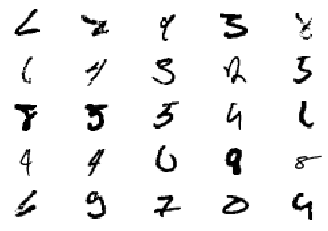

In [22]:
figure = plt.figure()
diag = 0
p    = 0        # Change this to get diff. scenarios we are plotting i.e. 0 -> w/o l1,l2, 1 -> wid l1, 2 -> wid l2, 3 -> wid l1 & l2

if len(act_img[p]) < 25:
  print('Not enough images to print') 
else:
  start = len(act_img[p])-25       # Printing last 25 images, that were wrongly predicted
  end   = len(act_img[p])
  for index in range(start, end):
            diag += 1
            plt.subplot(5, 5, diag)
            plt.axis('off')
            plt.imshow(act_img[p][index].reshape(28,28), cmap='gray_r') 
  
  t = start -1

  print ('    Actual Target Value in MNIST - Model w/o L1 & L2')
  print('   ',act_class[p][t+1],'    ',act_class[p][t+2],'      ',act_class[p][t+3],'      ',act_class[p][t+4],'        ',act_class[p][t+5])
  print('   ',act_class[p][t+6],'    ',act_class[p][t+7],'      ',act_class[p][t+8],'      ',act_class[p][t+9],'        ',act_class[p][t+10])
  print('   ',act_class[p][t+11],'    ',act_class[p][t+12],'      ',act_class[p][t+13],'      ',act_class[p][t+14],'        ',act_class[p][t+15])
  print('   ',act_class[p][t+16],'    ',act_class[p][t+17],'      ',act_class[p][t+18],'      ',act_class[p][t+19],'        ',act_class[p][t+20])
  print('   ',act_class[p][t+21],'    ',act_class[p][t+22],'      ',act_class[p][t+23],'      ',act_class[p][t+24],'        ',act_class[p][t+25])

  print('     Wrongly Predicted Classes - Model w/o L1 & L2')
  print('   ',pred_class[p][t+1],'    ',pred_class[p][t+2],'      ',pred_class[p][t+3],'      ',pred_class[p][t+4],'        ',pred_class[p][t+5])
  print('   ',pred_class[p][t+6],'    ',pred_class[p][t+7],'      ',pred_class[p][t+8],'      ',pred_class[p][t+9],'        ',pred_class[p][t+10])
  print('   ',pred_class[p][t+11],'    ',pred_class[p][t+12],'      ',pred_class[p][t+13],'      ',pred_class[p][t+14],'        ',pred_class[p][t+15])
  print('   ',pred_class[p][t+16],'    ',pred_class[p][t+17],'      ',pred_class[p][t+18],'      ',pred_class[p][t+19],'        ',pred_class[p][t+20])
  print('   ',pred_class[p][t+21],'    ',pred_class[p][t+22],'      ',pred_class[p][t+23],'      ',pred_class[p][t+24],'        ',pred_class[p][t+25])

# Visualizing Original Image, Predicted Class and Actual Class for scenario - With L1 

    Actual Target Value in MNIST - Model with L1 = 0.0005
    4      8        7        9          5
    5      9        8        8          5
    9      5        6        2          2
    5      7        7        8          5
    6      6        3        2          4
     Wrongly Predicted Classes - Model with L1 = 0.0005
    6      0        2        4          6
    6      4        0        3          6
    4      3        1        6          7
    3      1        2        2          3
    8      0        5        0          9


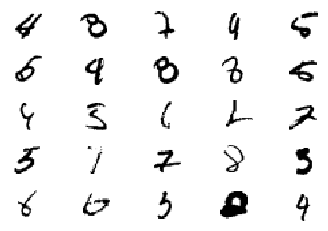

In [23]:
figure = plt.figure()
diag = 0
p    = 1        # Change this to get diff. scenarios we are plotting i.e. 0 -> w/o l1,l2, 1 -> wid l1, 2 -> wid l2, 3 -> wid l1 & l2

if len(act_img[p]) < 25:
  print('Not enough images to print') 
else:
  start = len(act_img[p])-25       # Printing last 25 images, that were wrongly predicted
  end   = len(act_img[p])
  for index in range(start, end):
            diag += 1
            plt.subplot(5, 5, diag)
            plt.axis('off')
            plt.imshow(act_img[p][index].reshape(28,28), cmap='gray_r') 
  
  t = start -1

  print ('    Actual Target Value in MNIST - Model with L1 = 0.0005')
  print('   ',act_class[p][t+1],'    ',act_class[p][t+2],'      ',act_class[p][t+3],'      ',act_class[p][t+4],'        ',act_class[p][t+5])
  print('   ',act_class[p][t+6],'    ',act_class[p][t+7],'      ',act_class[p][t+8],'      ',act_class[p][t+9],'        ',act_class[p][t+10])
  print('   ',act_class[p][t+11],'    ',act_class[p][t+12],'      ',act_class[p][t+13],'      ',act_class[p][t+14],'        ',act_class[p][t+15])
  print('   ',act_class[p][t+16],'    ',act_class[p][t+17],'      ',act_class[p][t+18],'      ',act_class[p][t+19],'        ',act_class[p][t+20])
  print('   ',act_class[p][t+21],'    ',act_class[p][t+22],'      ',act_class[p][t+23],'      ',act_class[p][t+24],'        ',act_class[p][t+25])

  print('     Wrongly Predicted Classes - Model with L1 = 0.0005')
  print('   ',pred_class[p][t+1],'    ',pred_class[p][t+2],'      ',pred_class[p][t+3],'      ',pred_class[p][t+4],'        ',pred_class[p][t+5])
  print('   ',pred_class[p][t+6],'    ',pred_class[p][t+7],'      ',pred_class[p][t+8],'      ',pred_class[p][t+9],'        ',pred_class[p][t+10])
  print('   ',pred_class[p][t+11],'    ',pred_class[p][t+12],'      ',pred_class[p][t+13],'      ',pred_class[p][t+14],'        ',pred_class[p][t+15])
  print('   ',pred_class[p][t+16],'    ',pred_class[p][t+17],'      ',pred_class[p][t+18],'      ',pred_class[p][t+19],'        ',pred_class[p][t+20])
  print('   ',pred_class[p][t+21],'    ',pred_class[p][t+22],'      ',pred_class[p][t+23],'      ',pred_class[p][t+24],'        ',pred_class[p][t+25])

#Visualizing Original Image, Predicted Class and Actual Class for scenario - With L2

    Actual Target Value in MNIST - Model with L2 = 0.0001
    4      9        0        9          0
    4      4        1        1          5
    0      8        8        3          7
    2      9        7        3          1
    9      6        7        9          4
     Wrongly Predicted Classes - Model with L2 = 0.0001
    7      4        5        4          6
    9      9        3        2          6
    6      7        2        2          1
    6      4        1        5          2
    7      8        2        2          9


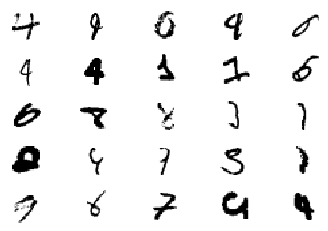

In [24]:
figure = plt.figure()
diag = 0
p    = 2        # Change this to get diff. scenarios we are plotting i.e. 0 -> w/o l1,l2, 1 -> wid l1, 2 -> wid l2, 3 -> wid l1 & l2

if len(act_img[p]) < 25:
  print('Not enough images to print') 
else:
  start = len(act_img[p])-25       # Printing last 25 images, that were wrongly predicted
  end   = len(act_img[p])
  for index in range(start, end):
            diag += 1
            plt.subplot(5, 5, diag)
            plt.axis('off')
            plt.imshow(act_img[p][index].reshape(28,28), cmap='gray_r') 
  
  t = start -1

  print ('    Actual Target Value in MNIST - Model with L2 = 0.0001')
  print('   ',act_class[p][t+1],'    ',act_class[p][t+2],'      ',act_class[p][t+3],'      ',act_class[p][t+4],'        ',act_class[p][t+5])
  print('   ',act_class[p][t+6],'    ',act_class[p][t+7],'      ',act_class[p][t+8],'      ',act_class[p][t+9],'        ',act_class[p][t+10])
  print('   ',act_class[p][t+11],'    ',act_class[p][t+12],'      ',act_class[p][t+13],'      ',act_class[p][t+14],'        ',act_class[p][t+15])
  print('   ',act_class[p][t+16],'    ',act_class[p][t+17],'      ',act_class[p][t+18],'      ',act_class[p][t+19],'        ',act_class[p][t+20])
  print('   ',act_class[p][t+21],'    ',act_class[p][t+22],'      ',act_class[p][t+23],'      ',act_class[p][t+24],'        ',act_class[p][t+25])

  print('     Wrongly Predicted Classes - Model with L2 = 0.0001')
  print('   ',pred_class[p][t+1],'    ',pred_class[p][t+2],'      ',pred_class[p][t+3],'      ',pred_class[p][t+4],'        ',pred_class[p][t+5])
  print('   ',pred_class[p][t+6],'    ',pred_class[p][t+7],'      ',pred_class[p][t+8],'      ',pred_class[p][t+9],'        ',pred_class[p][t+10])
  print('   ',pred_class[p][t+11],'    ',pred_class[p][t+12],'      ',pred_class[p][t+13],'      ',pred_class[p][t+14],'        ',pred_class[p][t+15])
  print('   ',pred_class[p][t+16],'    ',pred_class[p][t+17],'      ',pred_class[p][t+18],'      ',pred_class[p][t+19],'        ',pred_class[p][t+20])
  print('   ',pred_class[p][t+21],'    ',pred_class[p][t+22],'      ',pred_class[p][t+23],'      ',pred_class[p][t+24],'        ',pred_class[p][t+25])

#Visualizing Original Image, Predicted Class and Actual Class for scenario - With L1 & L2

    Actual Target Value in MNIST - Model with L1=0.0005 & L2 = 0.0001
    6      5        6        0          1
    6      0        6        8          2
    1      7        8        6          6
    9      2        6        3          9
    7      4        3        9          8
     Wrongly Predicted Classes - Model with L1=0.0005 & L2 = 0.0001
    1      9        4        2          5
    1      6        2        3          7
    2      1        3        5          5
    4      0        1        5          8
    1      9        7        3          9


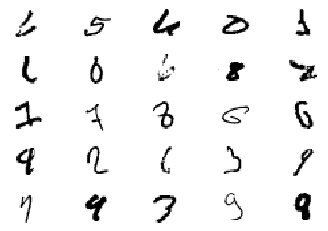

In [25]:
figure = plt.figure()
diag = 0
p    = 3        # Change this to get diff. scenarios we are plotting i.e. 0 -> w/o l1,l2, 1 -> wid l1, 2 -> wid l2, 3 -> wid l1 & l2

if len(act_img[p]) < 25:
  print('Not enough images to print') 
else:
  start = len(act_img[p])-25       # Printing last 25 images, that were wrongly predicted
  end   = len(act_img[p])
  for index in range(start, end):
            diag += 1
            plt.subplot(5, 5, diag)
            plt.axis('off')
            plt.imshow(act_img[p][index].reshape(28,28), cmap='gray_r') 
  
  t = start -1

  print ('    Actual Target Value in MNIST - Model with L1=0.0005 & L2 = 0.0001')
  print('   ',act_class[p][t+1],'    ',act_class[p][t+2],'      ',act_class[p][t+3],'      ',act_class[p][t+4],'        ',act_class[p][t+5])
  print('   ',act_class[p][t+6],'    ',act_class[p][t+7],'      ',act_class[p][t+8],'      ',act_class[p][t+9],'        ',act_class[p][t+10])
  print('   ',act_class[p][t+11],'    ',act_class[p][t+12],'      ',act_class[p][t+13],'      ',act_class[p][t+14],'        ',act_class[p][t+15])
  print('   ',act_class[p][t+16],'    ',act_class[p][t+17],'      ',act_class[p][t+18],'      ',act_class[p][t+19],'        ',act_class[p][t+20])
  print('   ',act_class[p][t+21],'    ',act_class[p][t+22],'      ',act_class[p][t+23],'      ',act_class[p][t+24],'        ',act_class[p][t+25])

  print('     Wrongly Predicted Classes - Model with L1=0.0005 & L2 = 0.0001')
  print('   ',pred_class[p][t+1],'    ',pred_class[p][t+2],'      ',pred_class[p][t+3],'      ',pred_class[p][t+4],'        ',pred_class[p][t+5])
  print('   ',pred_class[p][t+6],'    ',pred_class[p][t+7],'      ',pred_class[p][t+8],'      ',pred_class[p][t+9],'        ',pred_class[p][t+10])
  print('   ',pred_class[p][t+11],'    ',pred_class[p][t+12],'      ',pred_class[p][t+13],'      ',pred_class[p][t+14],'        ',pred_class[p][t+15])
  print('   ',pred_class[p][t+16],'    ',pred_class[p][t+17],'      ',pred_class[p][t+18],'      ',pred_class[p][t+19],'        ',pred_class[p][t+20])
  print('   ',pred_class[p][t+21],'    ',pred_class[p][t+22],'      ',pred_class[p][t+23],'      ',pred_class[p][t+24],'        ',pred_class[p][t+25])